In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import sys
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from time import time

import itertools
from sklearn.preprocessing import scale
from sklearn import preprocessing

import boto3
from io import BytesIO
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [2]:
'''
-----------------------------------------------------------------------------
--- Inputs
-----------------------------------------------------------------------------
'''
Interp = 'Interp'
Analysis = 'KMA'
DRrange = range(180,181,1)

'''
-----------------------------------------------------------------------------
--- Definitions
-----------------------------------------------------------------------------
'''
Results = 'Results'
Indicies = 'Indicies'
Response = 'Response'
Figures = 'Figures'

# Configuring S3
s3_bucket_name = 'jasper-ml-sagemaker'
role = get_execution_role()

client = boto3.client('s3')
resource = boto3.resource('s3')
my_bucket = resource.Bucket(s3_bucket_name)

In [3]:
'''
-----------------------------------------------------------------------------
--- Importing Base Data
-----------------------------------------------------------------------------
'''
# Dataset
dataKey = 'scaledData.csv'
obj = client.get_object(Bucket=s3_bucket_name, Key=dataKey)
dataSet = pd.read_csv(obj['Body'], header=None, index_col=None)

# Response Data
dataKey = 'FixedResponse.npy'
obj = client.get_object(Bucket=s3_bucket_name, Key=dataKey)
responseData = np.load(BytesIO(obj['Body'].read()))

In [ ]:
'''
-----------------------------------------------------------------------------
--- Loop for Multiple Dimensions
-----------------------------------------------------------------------------
'''

for Dimensions in DRrange:

    '''
    -----------------------------------------------------------------------------
    --- Importing Labels
    -----------------------------------------------------------------------------
    '''
    timeStart = time()

    resultsPath = '{}/{}/{}/{}/'.format(Results, Interp, Analysis, Dimensions)

    files = []
    for object_summary in my_bucket.objects.filter(Prefix=resultsPath):
        files.append(object_summary.key[len(resultsPath):])

    '''
    -----------------------------------------------------------------------------
    --- Converting labels to Characteristic Indicies
    -----------------------------------------------------------------------------
    '''

    # Import labels
    collectedIndicies = []
    for dataKey in files:
        obj = client.get_object(Bucket=s3_bucket_name, Key=resultsPath + dataKey)
        labels = pd.read_csv(obj['Body'], header=None)

        # Define data and initalise
        profile = dataSet.copy()
        profile['labels'] = labels
        charProfile = profile.groupby(['labels']).mean().values


        # Find the index of the most comparable profiles

        #note: is time consuming

        characteristicIndicies = []
        for j in range(len(charProfile)):
            characteristicIndicies.append(np.argmin(np.linalg.norm(dataSet.values-charProfile[j],axis=1)))

        collectedIndicies.append(np.flip(characteristicIndicies,axis=0))
        print('Completed indicies for Dim = {} & k = {}'.format(Dimensions,len(charProfile)))

    #Uploading Char Indicies
    indiciesPath = '{}/{}/{}/'.format(Indicies, Interp, Analysis)
    dataKey = '{}DimCharIndicies.npy'.format(Dimensions)

    np.save(dataKey,collectedIndicies)
    my_bucket.upload_file(dataKey,Key=indiciesPath + dataKey)
    os.remove(dataKey)

    print('Completed computing char indicies')


    '''
    -----------------------------------------------------------------------------
    --- Calculating Max Response
    -----------------------------------------------------------------------------
    '''
    charResponses = []
    for j in range(len(collectedIndicies)):
        responses = []
        for index in collectedIndicies[j]:
            responses.append(responseData[index])
        charResponses.append(responses)


    maxResponses = []
    centres = [len(x) for x in collectedIndicies]
    for j in range(len(charResponses)):
        maxResponses.append(max(charResponses[j]))

    # Formating Responses
    results = []
    results.append(np.flip(centres, axis=0))
    results.append(np.flip(maxResponses, axis=0))

    results = pd.DataFrame(results, ['centres','maxResponse']).transpose()
    results['responsePercentage'] = (results['maxResponse']- min(responseData))/(max(responseData)-min(responseData))

    # Uploading Responses
    responsePath = '{}/{}/{}/'.format(Response, Interp, Analysis)
    dataKey = '{}DimResponses.npy'.format(Dimensions)

    np.save(dataKey,collectedIndicies)
    my_bucket.upload_file(dataKey,Key=responsePath + dataKey)
    os.remove(dataKey)

    '''
    -----------------------------------------------------------------------------
    --- Plotting Response vs No Centres
    -----------------------------------------------------------------------------
    '''

    # Plotting Responses

    fig, axs = plt.subplots(2,1,figsize=(15,15))
    fig.suptitle('{} {} with {} Dimensions'.format(Interp, Analysis, Dimensions), fontsize = 16)
    fig.subplots_adjust(top=0.95)
    axs[0].scatter(results.centres,results.responsePercentage)
    axs[0].set_xlabel('Number of Clusters', fontsize = 16)
    axs[0].set_ylabel('Maximum Response Percentage', fontsize = 16)

    axs[1].scatter(results.centres[results.centres < 100], results.responsePercentage[results.centres < 100])
    axs[1].set_xlabel('Number of Clusters', fontsize = 16)
    axs[1].set_ylabel('Maximum Response Percentage', fontsize = 16)

    # Uploading 
    figuresPath = '{}/'.format(Figures)
    dataKey = '{}{}With{}.png'.format(Interp,Analysis,Dimensions)

    plt.savefig(dataKey)
    my_bucket.upload_file(dataKey,Key=figuresPath + dataKey)
    os.remove(dataKey)

    plt.show()
    print('Analysis for Dim = {} took {:.2f} seconds'.format(Dimensions, time()-timeStart))

Completed indicies for Dim = 180 & k = 1000
Completed indicies for Dim = 180 & k = 100
Completed indicies for Dim = 180 & k = 105
Completed indicies for Dim = 180 & k = 10
Completed indicies for Dim = 180 & k = 110
Completed indicies for Dim = 180 & k = 115
Completed indicies for Dim = 180 & k = 11
Completed indicies for Dim = 180 & k = 120
Completed indicies for Dim = 180 & k = 125
Completed indicies for Dim = 180 & k = 12
Completed indicies for Dim = 180 & k = 130
Completed indicies for Dim = 180 & k = 135
Completed indicies for Dim = 180 & k = 13
Completed indicies for Dim = 180 & k = 140
Completed indicies for Dim = 180 & k = 145
Completed indicies for Dim = 180 & k = 14
Completed indicies for Dim = 180 & k = 150
Completed indicies for Dim = 180 & k = 155
Completed indicies for Dim = 180 & k = 15
Completed indicies for Dim = 180 & k = 160
Completed indicies for Dim = 180 & k = 165
Completed indicies for Dim = 180 & k = 16
Completed indicies for Dim = 180 & k = 170
Completed indicie

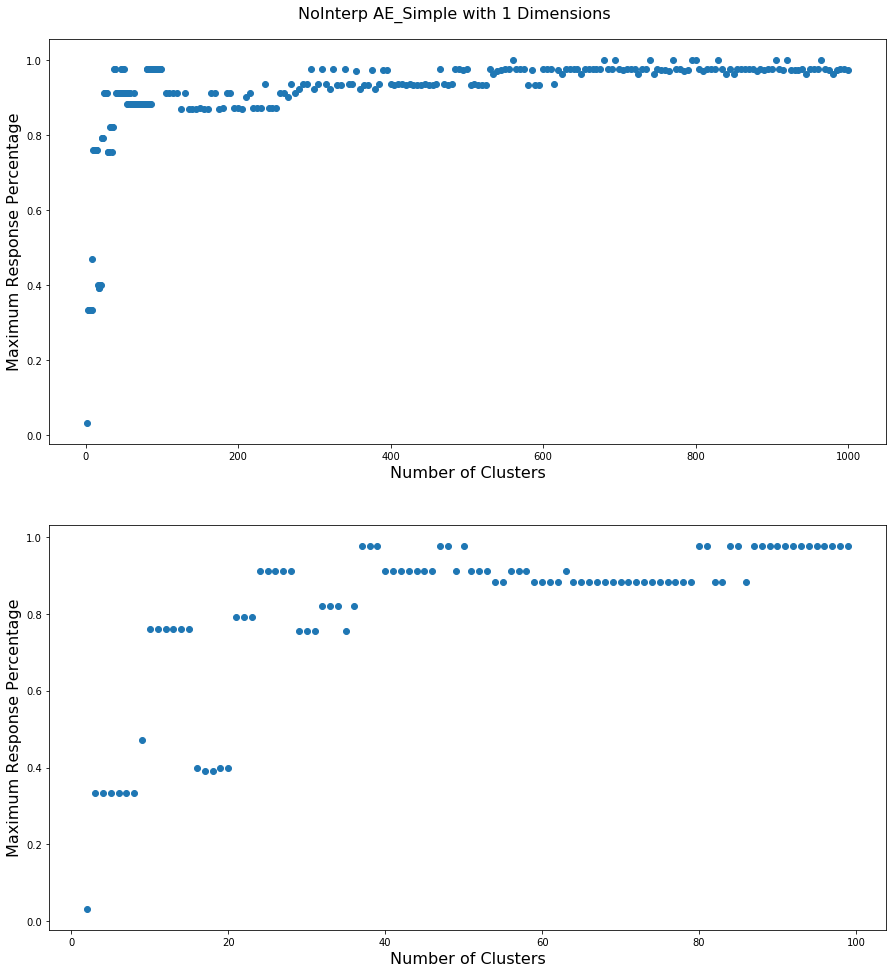